In [1]:
# UT-TOR-DATA-PT-01-2020-U-C Week 11
# Web Design Challenge
# Creates a stack chart showing results of all the parties on all the elections
# (c) Boris Smirnov

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import utilities as u

In [3]:
years_lst = [2004, 2006, 2008, 2011, 2015, 2019]
party_lst = ['LIB', 'CPC', 'NDP', 'BQ', 'GRN']

# I have custom names only for the parties in the list. Very convenient
p_df = u.parties_df[['Id', 'Custom Name']].dropna()
party_names = dict(zip(p_df['Id'], p_df['Custom Name']))

# Extending parties with "Other" - there were some independent candidates, who made into the parliament
party_lst += ['OTH']
party_names['OTH'] = 'Other'

party_colors = {
    'LIB': '#EA6D6A', # red
    'CPC': "#6495ED", # blue
    'NDP': "#F4A460", # orange
    'BQ' : "#87CEFA", # light blue
    'GRN': "#99C955", # green
    'OTH': "#A9A9A9"  # gray
}

In [4]:
# DataFrame with accumulated elections results for all years
accumulated_df = pd.DataFrame()

for year in years_lst:
    src_file = f"data{year}.csv"
    input_df = pd.read_csv(src_file)

    winners_df = input_df.groupby('FED Id').first()

    seats_grp = winners_df.groupby('Candidate Pid')
    seats_df = seats_grp[['Candidate Pid']].count()
    seats_df.columns = [f"{year}"]
    
    if not len(accumulated_df):
        accumulated_df[f"{year}"] = seats_df[f"{year}"]
    else:
        accumulated_df = accumulated_df.merge(seats_df, how="outer", left_index=True, right_index=True)

accumulated_df.fillna(value=0, inplace=True)
accumulated_df

,2004,2006,2008,2011,2015,2019
Candidate Pid,,,,,,
BQ,54.0,51.0,49.0,4.0,10.0,32.0
CPC,99.0,124.0,143.0,166.0,99.0,121.0
GRN,0.0,0.0,0.0,1.0,1.0,3.0
IND,0.0,1.0,2.0,0.0,0.0,1.0
LIB,135.0,103.0,77.0,34.0,184.0,157.0
NDP,19.0,29.0,37.0,103.0,44.0,24.0
NOA,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Preparind dataframe for stacking bars

# Here I accumulate all non-party candidates ('IND' and 'NOA') into one "party" 'OTH' (Other)
other_s = accumulated_df.loc[['IND', 'NOA']].sum() # sum up all their seats by year
other_s.name = 'OTH'
if 'OTH' not in accumulated_df.index: # do not add duplicate row
    accumulated_df = accumulated_df.append(other_s) # add summary row

# Delete non-party rows (but not 'OTH')
accumulated_df.drop(index=['IND', 'NOA'], inplace=True)

# Sort dataframe by total amount of seats for all the years
accumulated_df['Sum'] = accumulated_df.sum(axis=1)
accumulated_df.sort_values('Sum', ascending=False, inplace=True)
del(accumulated_df['Sum'])

# Now the index is in the right order for stacking
accumulated_df

,2004,2006,2008,2011,2015,2019
Candidate Pid,,,,,,
CPC,99.0,124.0,143.0,166.0,99.0,121.0
LIB,135.0,103.0,77.0,34.0,184.0,157.0
NDP,19.0,29.0,37.0,103.0,44.0,24.0
BQ,54.0,51.0,49.0,4.0,10.0,32.0
GRN,0.0,0.0,0.0,1.0,1.0,3.0
OTH,1.0,1.0,2.0,0.0,0.0,1.0


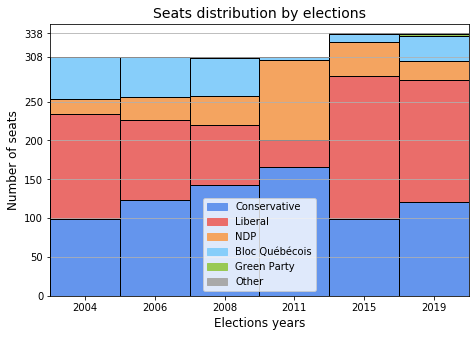

In [6]:
# Generate an all-in-one stack chart: all parties, all years

fig = plt.figure(figsize=(7.5, 5))
axes = plt.subplot()

axes.set_title(f"Seats distribution by elections", fontdict={'fontsize': 14})

bottoms = [0] * len(accumulated_df)
legend_handles = []

for party in accumulated_df.index:
    plt.bar(range(len(years_lst)), accumulated_df.loc[party],
            width=1, align='center', edgecolor='black', linewidth=1,
            color=party_colors[party], bottom=bottoms)
    bottoms = [a + b for (a, b) in zip(bottoms, accumulated_df.loc[party])]
    legend_handles += [mpatches.Patch(color=party_colors[party], label=party_names[party])]

# X-axis
axes.set_xlabel('Elections years', fontdict={'fontsize': 12})
axes.set_xticks([i for i in range(len(years_lst))])
axes.set_xticklabels([str(year) for year in years_lst])
axes.set_xlim(left=-0.5, right=len(years_lst) - 0.5)

# Y-axis
yticks_lst = list(range(0, 300, 50)) + [308, 338]
axes.set_ylabel('Number of seats', fontdict={'fontsize': 12})
axes.set_yticks(yticks_lst)
axes.set_ylim(top=350)
axes.yaxis.grid()

# Making a legend
# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
plt.legend(handles=legend_handles, loc='best')

plt.savefig(f"../images/summary_bars.svg", bbox_inches = 'tight')
plt.show()